<a href="https://www.kaggle.com/code/dsptlp/classification?scriptVersionId=163036425" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import packages
import os
import joblib
import numpy as np
import pandas as pd
import warnings
#import classification_report
from sklearn.metrics import classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn.metrics import roc_curve
#for model building
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
# Scaling
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# setting up options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

import warnings as wr
wr.filterwarnings("ignore") #to ignore the warnings

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

import lightgbm
from lightgbm import LGBMRegressor

import pickle 
print(pickle.format_version)

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


4.0


In [2]:
df=pd.read_csv("../input/heart-attack-analysis-prediction-dataset/heart.csv")
df.head(2)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.300000,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500000,0,0,2,1


In [3]:
# creating a copy of df
df1 = df

# define the columns to be encoded and scaled
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]

# encoding the categorical columns
df1 = pd.get_dummies(df1, columns = cat_cols, drop_first = True)

# defining the features and target
X = df1.drop(['output'],axis=1)
y = df1[['output']]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
X[con_cols] = scaler.fit_transform(X[con_cols])
print("The first 5 rows of X are")
X.head()

The first 5 rows of X are


,age,trtbps,chol,thalachh,oldpeak,sex_1,exng_1,caa_1,caa_2,caa_3,caa_4,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,slp_1,slp_2,thall_1,thall_2,thall_3
0,0.592593,0.750000,-0.110236,-0.092308,0.937500,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
1,-1.333333,0.000000,0.157480,1.046154,1.687500,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,-1.037037,0.000000,-0.566929,0.584615,0.375000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,0.074074,-0.500000,-0.062992,0.769231,0.000000,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
4,0.148148,-0.500000,1.795276,0.307692,-0.125000,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)

The shape of X_train is       (242, 22)
The shape of X_test is        (61, 22)
The shape of y_train is       (242, 1)
The shape of y_test is        (61, 1)


In [5]:
key = ['AdaBoostClassifier','LogisticRegression','KNeighborsClassifier','SVC','DecisionTreeClassifier','RandomForestClassifier','GradientBoostingClassifier','XGBClassifier','BernoulliNB']
value = [AdaBoostClassifier(),LogisticRegression(random_state=9), KNeighborsClassifier(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier(n_estimators = 100, random_state = 0), GradientBoostingClassifier(n_estimators = 300,max_depth=1,subsample=0.8,max_features=0.2), xgb.XGBClassifier(),BernoulliNB()]
models = dict(zip(key,value))

AdaBoostClassifier 0.7540983606557377
[[24  5]
 [10 22]]
0.8362068965517242
              precision    recall  f1-score   support

           0       0.71      0.83      0.76        29
           1       0.81      0.69      0.75        32

    accuracy                           0.75        61
   macro avg       0.76      0.76      0.75        61
weighted avg       0.76      0.75      0.75        61



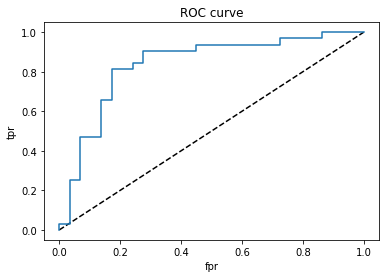

LogisticRegression 0.9016393442622951
[[27  2]
 [ 4 28]]
0.9396551724137931
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



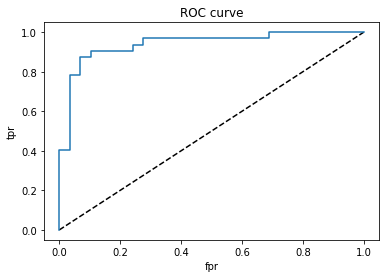

KNeighborsClassifier 0.8688524590163934
[[25  4]
 [ 4 28]]
0.9337284482758621
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



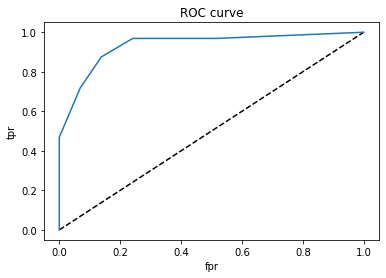

SVC 0.8524590163934426
[[27  2]
 [ 7 25]]
0.9299568965517241
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



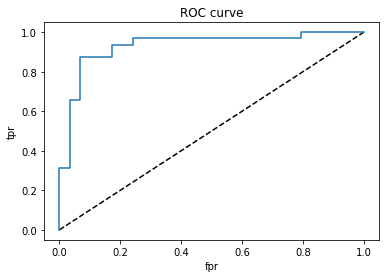

DecisionTreeClassifier 0.7377049180327869
[[22  7]
 [ 9 23]]
0.7386853448275862
              precision    recall  f1-score   support

           0       0.71      0.76      0.73        29
           1       0.77      0.72      0.74        32

    accuracy                           0.74        61
   macro avg       0.74      0.74      0.74        61
weighted avg       0.74      0.74      0.74        61



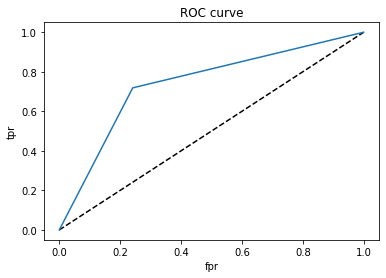

RandomForestClassifier 0.8852459016393442
[[26  3]
 [ 4 28]]
0.9385775862068965
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



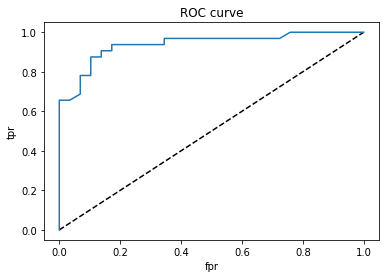

GradientBoostingClassifier 0.8688524590163934
[[26  3]
 [ 5 27]]
0.9148706896551724
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



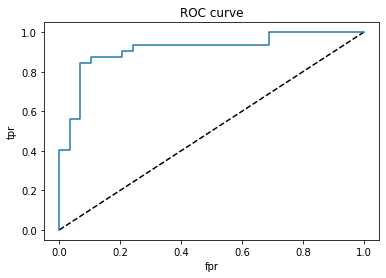

[04:45:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.8360655737704918
[[26  3]
 [ 7 25]]
0.9267241379310345
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        29
           1       0.89      0.78      0.83        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



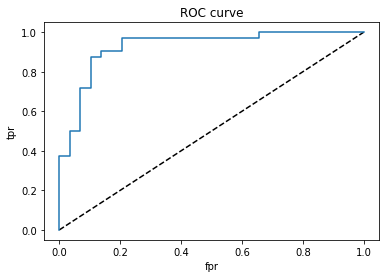

BernoulliNB 0.8524590163934426
[[27  2]
 [ 7 25]]
0.9364224137931034
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



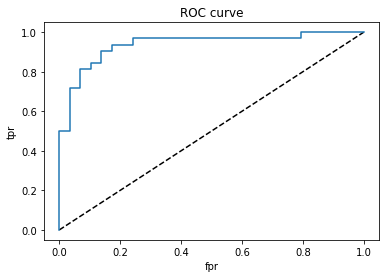

In [6]:
model_results =[]

for name,algo in models.items():
    model=algo
    model.fit(X_train,y_train)
    predict = model.predict(X_test)
    acc = accuracy_score(y_test, predict)
    conf = confusion_matrix(y_test, predict)
    
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test,y_pred_proba)
        
    model_results.append((name,acc,conf,roc_auc))
    print(name,acc)
    print(conf)    
    print(roc_auc)
    print(classification_report(y_test,predict))
    
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr,tpr, label='Knn')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC curve')
    plt.show()

In [7]:
model_results

[('AdaBoostClassifier',
  0.7540983606557377,
  array([[24,  5],
         [10, 22]]),
  0.8362068965517242),
 ('LogisticRegression',
  0.9016393442622951,
  array([[27,  2],
         [ 4, 28]]),
  0.9396551724137931),
 ('KNeighborsClassifier',
  0.8688524590163934,
  array([[25,  4],
         [ 4, 28]]),
  0.9337284482758621),
 ('SVC',
  0.8524590163934426,
  array([[27,  2],
         [ 7, 25]]),
  0.9299568965517241),
 ('DecisionTreeClassifier',
  0.7377049180327869,
  array([[22,  7],
         [ 9, 23]]),
  0.7386853448275862),
 ('RandomForestClassifier',
  0.8852459016393442,
  array([[26,  3],
         [ 4, 28]]),
  0.9385775862068965),
 ('GradientBoostingClassifier',
  0.8688524590163934,
  array([[26,  3],
         [ 5, 27]]),
  0.9148706896551724),
 ('XGBClassifier',
  0.8360655737704918,
  array([[26,  3],
         [ 7, 25]]),
  0.9267241379310345),
 ('BernoulliNB',
  0.8524590163934426,
  array([[27,  2],
         [ 7, 25]]),
  0.9364224137931034)]

# Hyperparameter Tuning RandomForest

In [8]:
# instantiating the object
model = RandomForestClassifier()

# setting a grid - not so extensive
parameters = {'n_estimators': [50, 100, 200],
    'max_depth': [2,3,10,15,20,25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# instantiating the GridSearchCV object
# For binary classification:
# 'accuracy': Calculates the accuracy of the classifier.
# 'precision': Measures the ability of the classifier not to label as positive a sample that is negative.
# 'recall': Measures the ability of the classifier to capture all the positive samples.
# 'f1': Combines precision and recall into a single metric.
# 'roc_auc': Computes the area under the Receiver Operating Characteristic (ROC) curve.

searcher = GridSearchCV(estimator = model, param_grid = parameters,cv=5, scoring='accuracy')

# fitting the object
searcher.fit(X_train, y_train)

# the scores
print("The best params are :", searcher.best_params_)
print("The best score is   :", searcher.best_score_)

# predicting the values
y_pred = searcher.predict(X_test)

# printing the test accuracy
print("The test accuracy score of model after hyper-parameter tuning is ", accuracy_score(y_test, y_pred))

The best params are : {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
The best score is   : 0.81828231292517
The test accuracy score of model after hyper-parameter tuning is  0.8688524590163934


# Hyperparameter Tuning LOGREG

In [9]:
# instantiating the object
model = LogisticRegression()

# Define a parameter grid
parameters = {
    'C': np.logspace(-3, 3, 7),  # Regularization parameter
    'penalty': ['l1', 'l2'],       # Regularization type
    'solver': ['liblinear']        # Solver algorithm
}

# instantiating the GridSearchCV object
# For binary classification:
# 'accuracy': Calculates the accuracy of the classifier.
# 'precision': Measures the ability of the classifier not to label as positive a sample that is negative.
# 'recall': Measures the ability of the classifier to capture all the positive samples.
# 'f1': Combines precision and recall into a single metric.
# 'roc_auc': Computes the area under the Receiver Operating Characteristic (ROC) curve.

searcher = GridSearchCV(estimator = model, param_grid = parameters,cv=5, scoring='accuracy')

# fitting the object
searcher.fit(X_train, y_train)

# the scores
print("The best params are :", searcher.best_params_)
print("The best score is   :", searcher.best_score_)

# predicting the values
y_pred = searcher.predict(X_test)

# printing the test accuracy
print("The test accuracy score of model after hyper-parameter tuning is ", accuracy_score(y_test, y_pred))

The best params are : {'C': 100.0, 'penalty': 'l1', 'solver': 'liblinear'}
The best score is   : 0.8428571428571429
The test accuracy score of model after hyper-parameter tuning is  0.8688524590163934


# TURNING LOGREG MODEL INTO SQL IMPLEMENTATION

BernoulliNB 0.8688524590163934
[[25  4]
 [ 4 28]]
0.9245689655172413
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



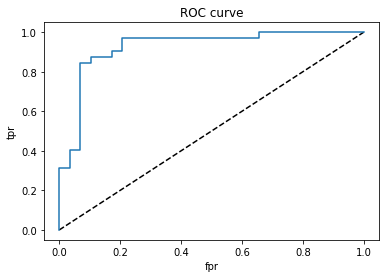

In [10]:
model=LogisticRegression(random_state=9,C=100.0, penalty= 'l1', solver= 'liblinear')
model.fit(X_train,y_train)
predict = model.predict(X_test)
acc = accuracy_score(y_test, predict)
conf = confusion_matrix(y_test, predict)

y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test,y_pred_proba)

print(name,acc)
print(conf)    
print(roc_auc)
print(classification_report(y_test,predict))

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [11]:
coefficients = model.coef_[0]
# Get the feature names
feature_names = X_train.columns

intercept = model.intercept_[0]

In [12]:
# Create a DataFrame to display the coefficients along with the feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Print the DataFrame
print(coefficients_df)

      Feature  Coefficient
0         age     0.373036
1      trtbps    -0.535699
2        chol    -0.168517
3    thalachh     0.531951
4     oldpeak    -0.842710
5       sex_1    -1.997421
6      exng_1    -1.032913
7       caa_1    -2.788309
8       caa_2    -3.964758
9       caa_3    -2.257028
10      caa_4     5.069104
11       cp_1     0.657235
12       cp_2     2.053223
13       cp_3     2.878058
14      fbs_1     0.621752
15  restecg_1     0.476206
16  restecg_2    -0.271695
17      slp_1    -0.221878
18      slp_2     1.625722
19    thall_1     0.667434
20    thall_2     0.284623
21    thall_3    -1.176603


In [13]:
print(coefficients)
print(intercept)

[ 0.37303592 -0.53569859 -0.16851653  0.53195105 -0.84271049 -1.99742106
 -1.03291337 -2.78830923 -3.96475825 -2.25702823  5.06910362  0.6572353
  2.05322281  2.87805756  0.62175154  0.47620597 -0.27169467 -0.2218783
  1.62572174  0.66743363  0.2846228  -1.17660332]
1.4753487122207327


In [14]:
"""
SELECT *,
       1 / (1 + EXP(-1 * (
           -- Intercept
           <intercept> +
           -- Coefficients for each feature
           <coef_1> * feature_1 +
           <coef_2> * feature_2 +
           -- ... Repeat for all features ...
           <coef_n> * feature_n
       ))) AS predicted_probability
FROM your_table;
"""

'\nSELECT *,\n       1 / (1 + EXP(-1 * (\n           -- Intercept\n           <intercept> +\n           -- Coefficients for each feature\n           <coef_1> * feature_1 +\n           <coef_2> * feature_2 +\n           -- ... Repeat for all features ...\n           <coef_n> * feature_n\n       ))) AS predicted_probability\nFROM your_table;\n'